### - Jay Bhanushali  

### - 60009200047  

### - K2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Decision Tree Classifier model from Scratch on PlayTennis dataset 

In [2]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("./PlayTennis.csv")
df.head()

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes


In [4]:
df.info

<bound method DataFrame.info of      outlook  temp humidity  windy play
0      sunny   hot     high  False   no
1      sunny   hot     high   True   no
2   overcast   hot     high  False  yes
3      rainy  mild     high  False  yes
4      rainy  cool   normal  False  yes
5      rainy  cool   normal   True   no
6   overcast  cool   normal   True  yes
7      sunny  mild     high  False   no
8      sunny  cool   normal  False  yes
9      rainy  mild   normal  False  yes
10     sunny  mild   normal   True  yes
11  overcast  mild     high   True  yes
12  overcast   hot   normal  False  yes
13     rainy  mild     high   True   no>

### Tree class & Node class

In [5]:
class Node:
    def __init__(self, feature_index=None, threshold=None,
                left=None, right=None,info_gain=None,value=None):
        # decision node atributes
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain

        # leaf node attribute
        self.value = value

class DecisionTreeClassifier_scratch:
    def __init__(self,min_samples_split=2,max_depth=2,mode='gini'):

        # initializing the root of the tree
        # tge root will be used to traverse through the tree
        self.root = None
        self.mode = mode

        # stopping conditions
        # if number of samples is less than min_samples_split 
        #       then consider it as leaf node (no more splitting)

        self.min_samples_split=min_samples_split

        # if depth reaches the max_depth then dont split the tree further
        self.max_depth=max_depth

    def build_tree(self,data,curr_depth=0):
        # Build the tree recursively
        #   all rows and columns from starting index to secondlast index
        X = data[:,:-1] # trainig features
        y = data[:,-1] # (target) feature to be classified 
        no_samples, no_features = np.shape(X) # number of samples , number of features

        # split untill stopping conditions are met
        if no_samples >=self.min_samples_split and curr_depth <= self.max_depth:
            # find the best split
            # best split is a dictionary returned by the best_split function
            best_split = self.get_best_split(data, no_samples, no_features)
            #   all rows and last column

            # zero information gain means that node is already pure (leaf), 
            # hence info gain must be positive for spliting

            if best_split['info_gain'] > 0:

                # reursion
                lst = self.build_tree(best_split["left_data"], curr_depth+1)  # left sub tree
                rst = self.build_tree(best_split["right_data"], curr_depth+1) # right sub tree

                return Node(best_split["feature_index"], 
                            best_split["threshold"], 
                            lst, rst, 
                            best_split["info_gain"]) # as its not a leat node we donot pass 'value' 

        # if splitting conditions is not met ... we have reached a leaf node
        # compute leaf value
        leafValue = self.calc_leaf_value(y)
        return Node(value = leafValue)


    def get_best_split(self, data, no_samples, no_features):
        best_split = {}
        max_info_gain = -float('inf') # selected minimum value for max info gain : -ve infinity

        # iterate over all features
        for fi in range(no_features):
            feature_value = data[:,fi]
            possible_thresholds = np.unique(feature_value)
            # threshhold values are real num and 
            # it is practically impossible to iterate through all the threshhold values
            # thus we make a finite list of possible_thresholds
            for th in possible_thresholds:

                # splitting the data into left_data and right_data
                left_data, right_data = self.split(data,fi,th)

                # ensuring that any of the and right_data is not empty
                if len(left_data) > 0 and len(right_data) > 0:
                    y = data[:,-1]
                    left_y = left_data[:,-1]
                    right_y = right_data[:,-1]

                    # computing the info gain based on the mode specified (default gini)
                    curr_info_gain = self.compute_info_gain(y, left_y, right_y, self.mode)

                    # if we get higher information gain than previous then we select that split
                    if curr_info_gain > max_info_gain:
                        best_split['feature_index'] = fi
                        best_split['threshold'] = th
                        best_split['left_data'] = left_data
                        best_split['right_data'] = right_data
                        best_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split


    def split(self, data, feature_index, threshold):

        # split the into left child and right child based on threshhold
        left_data = np.array([row for row in data if row[feature_index] <= threshold])
        right_data = np.array([row for row in data if row[feature_index] > threshold])
        return left_data, right_data

    def compute_info_gain(self, parent, left, right, mode='entropy'):
        # computing left weight (wl) & right weight (wr)
        wl = len(left)/len(parent)
        wr = len(right)/len(parent)

        if mode == 'entropy':
            # ig = information gain
            ig = self.entropy(parent) - ( wl*self.entropy(left) + wr*self.entropy(right) )
        else:
            ig = self.gini_index(parent) - ( wl*self.gini_index(left) + wr*self.gini_index(right) )

        return ig

    def entropy(self, y):
        entropy = 0
        labels = np.unique(y) # class labels
        for l in labels:
            p = len(y[y == l]) / len(y)
            entropy += -p * np.log2(p)
        return entropy

    def gini_index(self,y):
        g = 0
        labels = np.unique(y) # class labels
        for l in labels:
            p = len(y[y == l]) / len(y)
            g += p**2
        gi = 1 - g
        return gi

    def calc_leaf_value(self,y):
        y = list(y)
        return max(y, key=y.count)

    def print_tree(self,tree=None,indent="  "):
        if not tree:
            tree = self.root
        if tree.value is not None: # print value of leaf node
            print(tree.value)

        else:
            print(f"X_ {tree.feature_index} <=  {tree.threshold} ? Info gain = {tree.info_gain}")
            print(f"{indent}left:",end='')
            self.print_tree(tree.left, indent+indent)
            print(f"{indent}right:",end='')
            self.print_tree(tree.right, indent+indent)

    def fit(self, X, y):
        data = np.concatenate((X,y),axis=1)
        self.root = self.build_tree(data)

    def predict(self,X):
        # predict set of values
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions

    def make_predictions(self,x,tree):
        # to predict a single data point

        if tree.value != None: # leaf node
            return tree.value 
        feature_val = x[tree.feature_index] # extracting feature value at a giveb feature index
        if feature_val <= tree.threshold:
            return self.make_predictions(x,tree.left)
        else:
            return self.make_predictions(x,tree.right)        

### Train - Test Split

In [6]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)

### Fit the model

In [7]:
model = DecisionTreeClassifier_scratch(min_samples_split=2, max_depth=3, mode='gini')
model.fit(X_train,y_train)
model.print_tree()

X_ 0 <=  overcast ? Info gain = 0.09917355371900827
  left:yes
  right:X_ 2 <=  high ? Info gain = 0.3000000000000001
    left:no
    right:X_ 3 <=  False ? Info gain = 0.11999999999999983
        left:yes
        right:X_ 0 <=  rainy ? Info gain = 0.5
                left:no
                right:yes


In [8]:
all_features = list(df.columns)
all_features

['outlook', 'temp', 'humidity', 'windy', 'play']

### Testing & testing the model

train data result

In [9]:
y_train_pred = model.predict(X_train)
accuracy_score(y_train, y_train_pred)

1.0

test data result

In [10]:
y_test_pred = model.predict(X_test) 
accuracy_score(y_test, y_test_pred)

0.6666666666666666

Accuracy on testing data is 66.66%

# Sklearn Decision Tree Classifier model on iris dataset 

In [11]:
iris = pd.read_csv('./Iris.csv')
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [12]:
iris.drop('Id',axis=1,inplace=True)
iris

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [13]:
X = iris.iloc[:,:-1]
y = iris.Species

In [14]:
iris_model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=1)
iris_model.fit(X_train,y_train)

train_pred = iris_model.predict(X_train)
accuracy_score(y_train, train_pred)

1.0

In [15]:
test_pred = iris_model.predict(X_test)
accuracy_score(y_test, test_pred)

0.9666666666666667

### Print Decision Tree

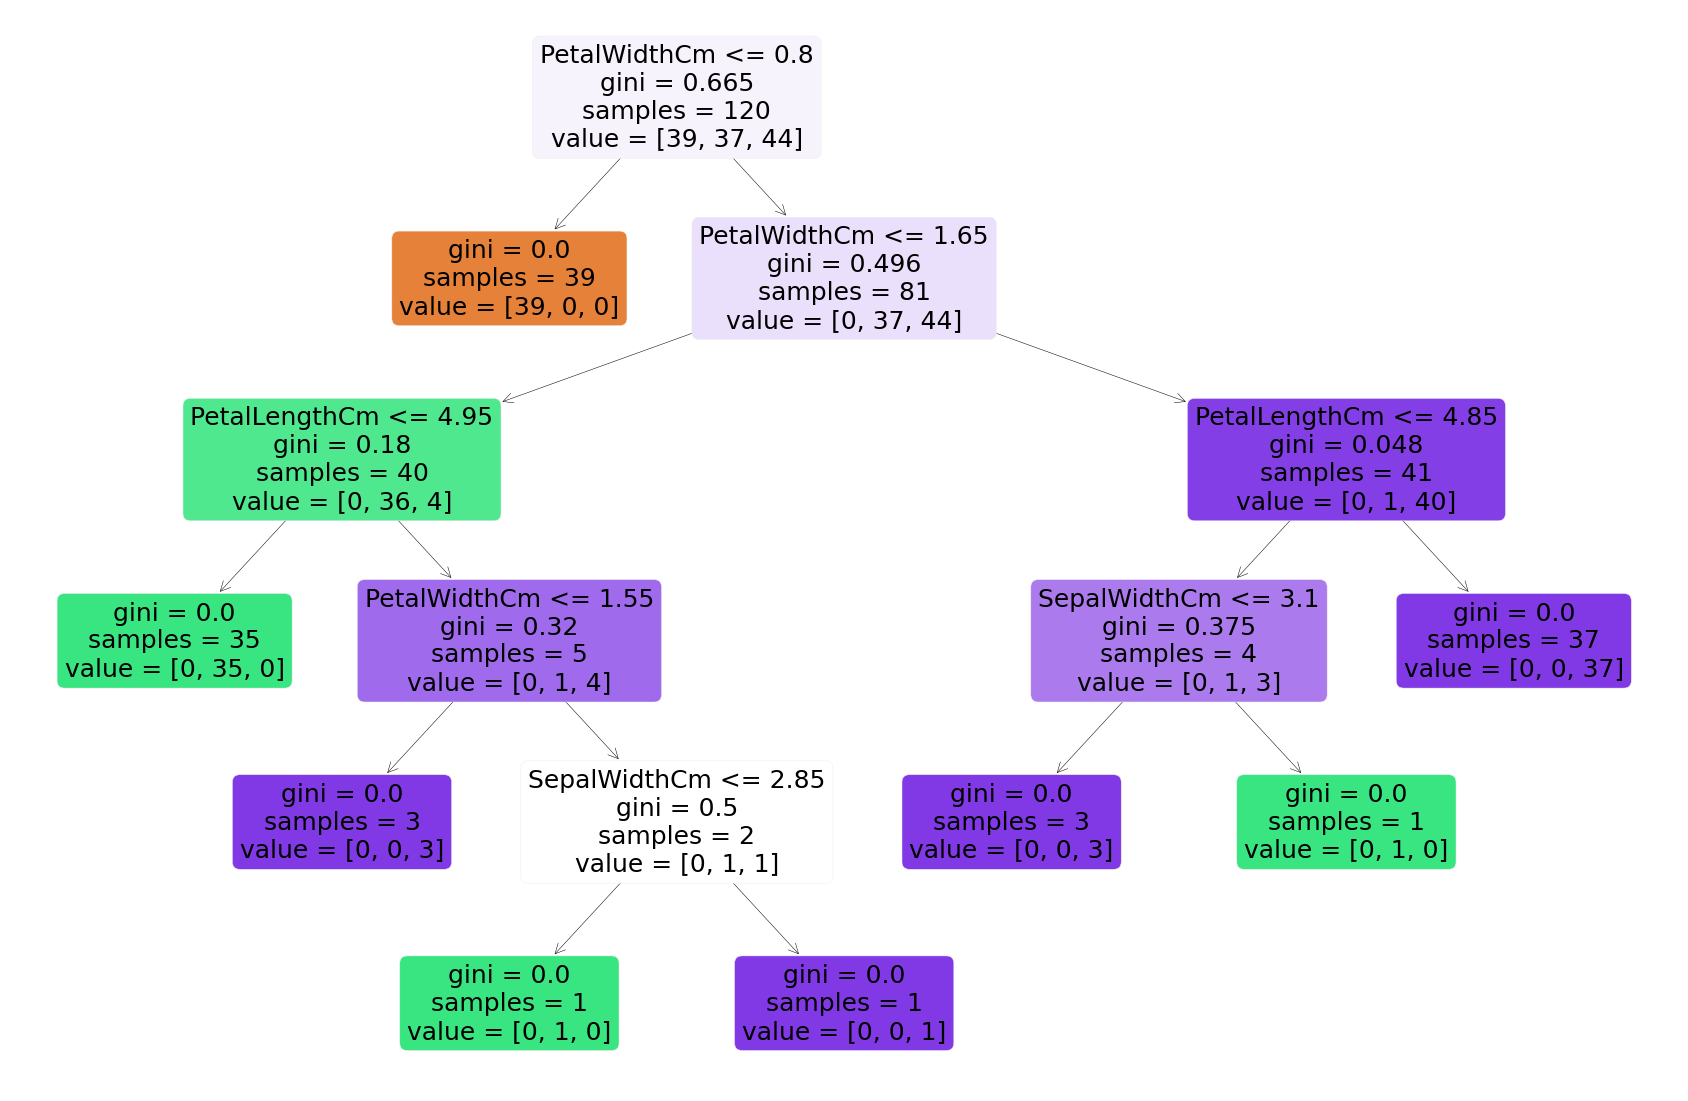

In [16]:
plt.figure(figsize=(30,20))  
_ = tree.plot_tree(iris_model, feature_names = iris.columns[:-1], 
             filled=True, fontsize=25, rounded = True)
plt.show()